# Пользователи и товары (работа с папками)

## Для анализа выполним несколько задач

1. Соберём все данные из папки data в один датафрэйм, имеющий следующие столбцы: колонки из самих файлов (product_id, quantity), а также имя пользователя (name), и дата этих покупок (date), соответствует названию папки, где лежит папка с пользователем)

2. Какой пользователь купил больше всего товаров?

3. Найдём топ-10 товаров по числу проданных единиц за всё время и построим барплот. Сколько было продано единиц товара с product_id=56?

4. Визуализируем продажи по дням.

5. Сколько пользователей приобрели какой-либо товар повторно (более 1 раза)? 

In [9]:
# Импортируем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [10]:
# Задаем настройки

from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style="darkgrid")

## 1. Соберем все данные в один датафрейм, имеющий столбцы
## prodact_id, quantity, name, date

In [11]:
# Для выполнения этого задания воспользуемся библиотекой os

# Пропишем путь до папки, с которой буем работать
path_to_dir = 'data'

# Создадим пустой датафрейм. С ним будем объединять остальные
user_sales = pd.DataFrame()

# С помощью цикла будем записывать путь к файлу в строку
for root, dirs, files in os.walk(path_to_dir, topdown=False):
    for name in files:
        path_to_one_file = os.path.join(root, name)
        
        # Создадим датафрейм для этого пути
        open_df = pd.read_csv(path_to_one_file)
 
        # Преобразуем строку
        # и из каждой строки добавим еще в столбцы
        # name и date -2 и -3 элементы
        open_df['name'] = path_to_one_file.split('/')[-2]
        open_df['date'] = path_to_one_file.split('/')[-3]

        # Объединим датафреймы из разных файлов в один
        user_sales = pd.concat((user_sales, open_df), ignore_index=True)

In [12]:
# Удалим столбец с индексами

user_sales = user_sales.drop(columns=['Unnamed: 0'])

In [13]:
# Переведем колонку date в формат даты

user_sales['date'] = pd.to_datetime(user_sales.date, dayfirst=True)

In [14]:
user_sales.head()

,product_id,quantity,name,date
0,18,4,Petr_Fedorov,2020-12-07
1,94,4,Petr_Fedorov,2020-12-07
2,95,2,Vasiliy_Ivanov,2020-12-07
3,83,3,Vasiliy_Ivanov,2020-12-07
4,64,1,Vasiliy_Ivanov,2020-12-07


## 2. Выясним, какой пользователь купил больше всего товаров

In [15]:
# Делаем группировку по имени и суммируем количество покупок

user_sales.groupby('name') \
          .agg({'quantity': 'sum'}) \
          .rename(columns={'quantity': 'quantity_sum'}) \
          .sort_values(by=['quantity_sum'], ascending=False) \
          .query('quantity_sum == quantity_sum.max()') \
          .index \
          .to_list()

['Alexey_Smirnov', 'Petr_Smirnov']

## 3. Найдём топ-10 товаров по числу проданных единиц за всё время и построим барплот. Сколько было продано единиц товара с product_id=56?

In [16]:
# Перед построением диаграммы подготовим датафрейм

# top_10
top_10 = user_sales.groupby('product_id') \
          .agg({'quantity': 'sum'}) \
          .rename(columns={'quantity': 'sum_sales'}) \
          .reset_index() \
          .sort_values(by=['sum_sales'], ascending=False)[:10] \
          .sort_values(by='product_id')

<AxesSubplot:xlabel='product_id', ylabel='sum_sales'>

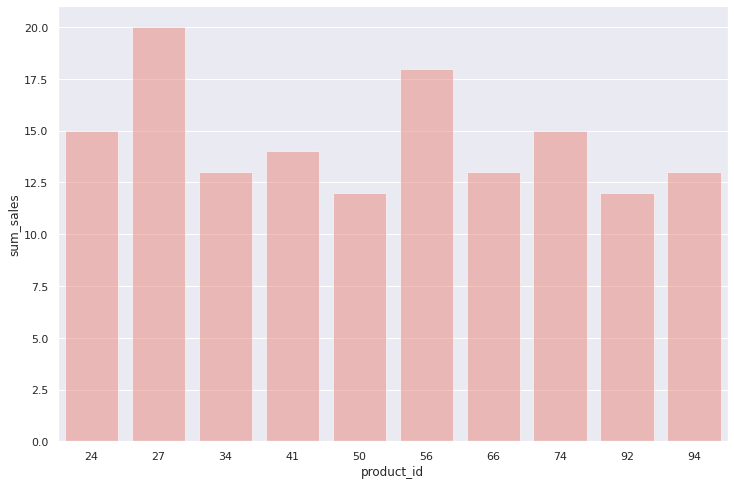

In [17]:
# Визуализируем данные

sns.barplot(data=top_10,
            x='product_id',
            y='sum_sales',
            color='salmon', 
            alpha=0.55,
            order=top_10.product_id.unique())

# С product_id = 56 было продано 18 единиц

## 4. Визуализируем продажи по дням

In [18]:
# Подготовим данные для построение barplot

date_sales = user_sales.groupby('date') \
                       .agg({'quantity': 'sum'}) \
                       .rename(columns={'quantity': 'sum_sales'}) \
                       .reset_index()
date_sales

,date,sum_sales
0,2020-12-03,60
1,2020-12-04,113
2,2020-12-05,61
3,2020-12-06,15
4,2020-12-07,94
5,2020-12-08,68
6,2020-12-09,69


[Text(0, 0, '2020-12-03'),
 Text(1, 0, '2020-12-04'),
 Text(2, 0, '2020-12-05'),
 Text(3, 0, '2020-12-06'),
 Text(4, 0, '2020-12-07'),
 Text(5, 0, '2020-12-08'),
 Text(6, 0, '2020-12-09')]

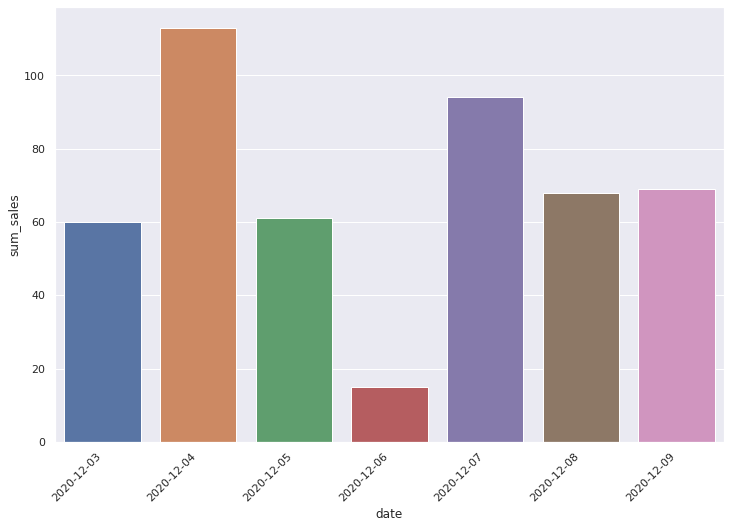

In [19]:
# Строим график

fig, ax = plt.subplots()    
fig = sns.barplot(x="date",
                  y="sum_sales",
                  data=date_sales, 
                  estimator=sum,
                  ci=None,
                  ax=ax)

x_dates = date_sales['date'].dt.strftime('%Y-%m-%d').sort_values()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

In [20]:
# Из графика видно:
# 4 декабря было куплено почти в два раза больше товаров, чем в предыдущий день
# Максимальное число товаров было продано 4 декабря
# Меньше всего товаров было приобретено 6 декабря
# 8 и 9 декабря было продано примерно одинаковое число товаров

## 5. Сколько пользователей приобрели какой-либо товар повторно (более 1 раза)? 

In [21]:
# Повтором будем считать покупку товара с одинаковым product_id, совершенную в разные дни
# С помощью drop_duplicates уберем покупки, совершенные повторно в один и тот же день

user_sales.drop_duplicates(subset=['name', 'product_id', 'date']) \
          .groupby(['name', 'product_id']) \
          .agg({'date': 'count'}) \
          .query('date > 1')

# Два пользователя приобрели какой-либо товар повторно

,,date
name,product_id,
Anton_Ivanov,15,2
Petr_Fedorov,94,2
